In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from functools import partial

from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore

from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


# Field scan RUN 5: EL = 2375 V/cm, 5GG/s

## Fix S2 window

In [13]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/'
pattern = 'FieldScan_5GSsec_Anode{}V_Gate{}V'
print(extract_voltage_pairs(base_dir, pattern))

[[1950   50]
 [2000  100]
 [2100  200]
 [2500  600]
 [3000 1100]
 [3500 1600]
 [4000 2100]]


In [37]:
subdir_fix = os.path.join(base_dir, pattern.format(2000, 100))
os.listdir(base_dir), subdir_fix
files_fix = glob(subdir_fix+'/*.wfm')
window_s2 = S2Window(subdir_fix, batch_size=50)

In [ ]:
window_s2.compute_average_s2_window()
window_s2.s1_avg, window_s2.s2_start_avg, window_s2.s2_end_avg, window_s2.duration

(-3.364577319587628e-06,
 6.15316907216495e-06,
 2.2235752577319588e-05,
 1.608258350515464e-05)

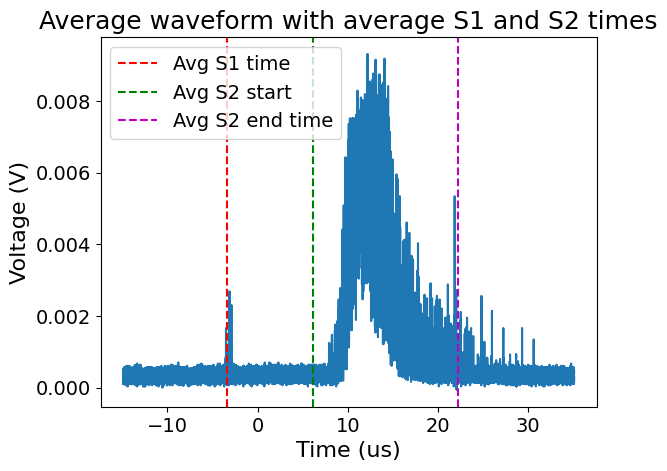

In [ ]:
window_s2.batch_size = 10
window_s2.plot_avg_values()

## Integrate S2 for all fields

In [48]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/'
pattern = 'FieldScan_5GSsec_Anode{}V_Gate{}V'

area_extractor = partial(
    S2AreaExtractor,
    threshold_bs=0.07,
    s2_duration=window_s2.duration,
    bs_t_window=(-1.5e-5, -1.0e-5),
    bs_v_window=(-0.005, 0.005)
)

In [65]:
analyzer = FieldScanAnalyzer(
    base_dir,
    n_files=10_000,
    pattern=pattern,
    to_drop=[(4000, 2100)],
    areaExtractor=area_extractor,
    fitter=GaussianFitter,
    WindowS2=S2Window,
    hist_cuts=(-5, 120),
    nbins=120,
    EL_gap=0.8,
    drift_gap=1.4
)

In [66]:
s2_areas_cuts, s2_areas = analyzer.analyze();

Integrating 10000 files for EL 1950 V, Gate 50 V
Found 500 batches of files in /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
Found S2 start at 8.72 us for EL 1950 V, Gate 50 V
Integrating 10000 files for EL 2000 V, Gate 100 V
Found 500 batches of files in /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
Found S2 start at 7.32 us for EL 2000 V, Gate 100 V
Integrating 10000 files for EL 2100 V, Gate 200 V
Found 500 batches of files in /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in fi

<Axes: title={'center': 'Drift field scan, EL field: 2375.0 kV/cm'}, xlabel='S2 Area (mV*us)', ylabel='Counts'>

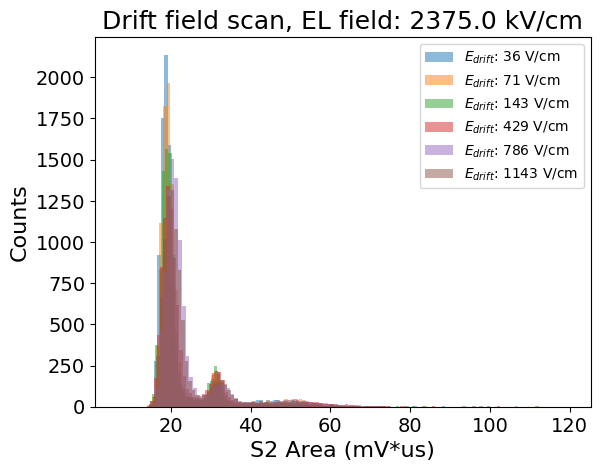

In [51]:
analyzer.plot_histograms()

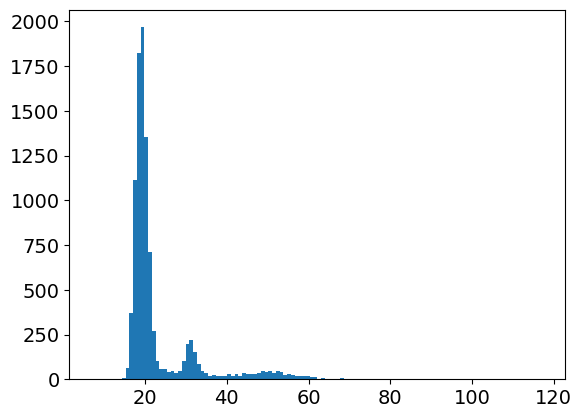

In [71]:
plt.hist(analyzer.s2_areas_cuts[100], bins=analyzer.nbins);

50 V: amplitude=1973.48, mean=23.43, sigma=1.60)
50 V: amplitude=73.24, mean=39.05, sigma=-10.06)
100 V: amplitude=2046.89, mean=23.57, sigma=1.66)
100 V: amplitude=81.62, mean=37.16, sigma=-13.69)
200 V: amplitude=1778.31, mean=23.40, sigma=1.66)
200 V: amplitude=236.23, mean=38.64, sigma=-1.90)
600 V: amplitude=1460.39, mean=23.78, sigma=2.01)
600 V: amplitude=233.35, mean=38.79, sigma=-2.31)
1100 V: amplitude=1651.71, mean=25.14, sigma=2.08)
1100 V: amplitude=81.74, mean=36.22, sigma=15.31)
1600 V: amplitude=1523.89, mean=24.57, sigma=2.21)
1600 V: amplitude=165.87, mean=39.69, sigma=-3.66)


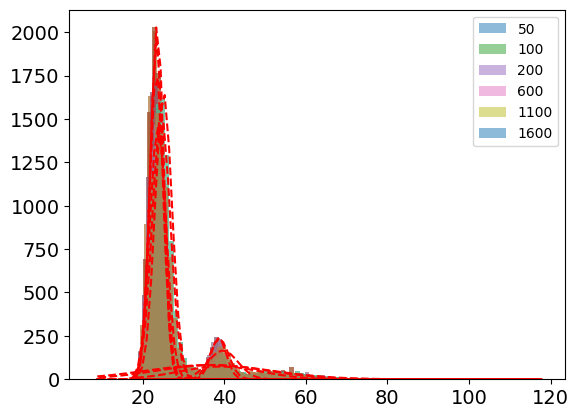

In [8]:
analyzer.fit_histograms_2peaks(sep_A=32);

[(0.0, 60.0)]

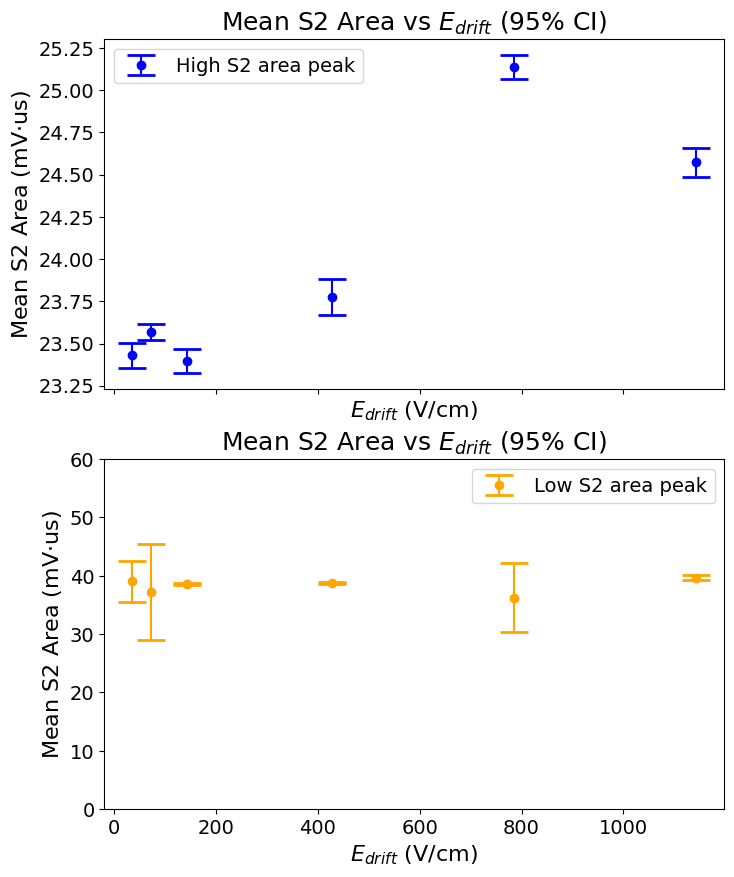

In [10]:
ax = analyzer.plot_s2_vs_field()
ax[1].set(ylim=(0, 60))

In [8]:
fields_over_lim = check_fields(analyzer.voltage_pairs, analyzer.E_el, analyzer.E_drift )
E_el0, E_drift = fields_over_lim[0]


 [2100  700]
 [2150  750]
 [2200  800]
 [2600 1200]
 [3100 1700]
 [3600 2200]
 [4100 2700]] V


In [18]:
print([round(e, 1) for e in analyzer.E_drift])

[35.7, 42.9, 46.4, 50.0, 53.6, 71.4, 107.1, 178.6, 250.0, 321.4, 392.9, 428.6, 464.3, 500.0, 535.7, 571.4, 857.1, 1214.3, 1571.4, 1928.6]


In [64]:
mean_p1, ci95_p1 = zip(*analyzer.fit_results_p1.values())
mean_p2, ci95_p2 = zip(*analyzer.fit_results_p2.values())
E_d = [analyzer.E_dr_dict[v] for v in analyzer.fit_results_p1.keys()]
ax = plt.gca()
ax2 = ax.twinx()
ax.errorbar(E_d, mean_p1, yerr=ci95_p1, fmt='o', color='blue', capsize=10, capthick=2, label='High S2 area peak')
ax2.errorbar(E_d[:-1], mean_p2[:-1], yerr=ci95_p2[:-1], fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')
ax.set(xlabel='Drift Field (V/cm)', ylabel='S2 Area (PE)', title='S2 Area vs Drift Field at EL=1450 V/cm')

AttributeError: 'FieldScanAnalyzer' object has no attribute 'fit_results_p1'

# Ch1/Ch4

In [62]:
analyzer = FieldScanAnalyzer(
    base_dir,
    n_files=3_000,
    pattern=pattern,
    to_drop=[(1950,   50),
       (2000,  100),
       (2100,  200),
       (2500,  600),
       (3000, 1100)],
    areaExtractor=area_extractor,
    fitter=GaussianFitter,
    WindowS2=S2Window,
    hist_cuts=(-5, 120),
    nbins=120,
    EL_gap=0.8,
    drift_gap=1.4
)

 [4000 2100]] V


In [63]:
analyzer.analyze()

Integrating 3000 files for EL 3500 V, Gate 1600 V
Found 500 batches of files in /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3500V_Gate1600V
No S1 or S2 found in file set
No S1 or S2 found in file set
Found S2 start at 4.07 us for EL 3500 V, Gate 1600 V
Integrating 3000 files for EL 4000 V, Gate 2100 V
Found 1000 batches of files in /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set
No S1 or S2 found in file set


ValueError: zero-size array to reduction operation minimum which has no identity